# jobflow

[`jobflow`](https://materialsproject.github.io/jobflow/index.html) and [`atomate2`](https://materialsproject.github.io/atomate2/index.html) are key packages of the [Materials Project](https://materialsproject.org/) . `jobflow` was especially designed to simplify the execution of dynamic workflows -- when the actual number of jobs is dynamically determined upon runtime instead of being statically fixed before running the workflow(s). `jobflow`'s overall flexibility allows for building workflows that go beyond the usage in materials science. `jobflow` serves as the basis of `atomate2`, which implements data generation workflows in the context of materials science and will be used for data generation in the Materials Project in the future.

## Define workflow with jobflow

We start by importing the job decorator and Flow class from `jobflow` and the respective PWD tools.

In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

In [3]:
from python_workflow_definition.jobflow import write_workflow_json

## Quantum Espresso Workflow
We will use the knowledge from the previous arithmetic workflow example to create the Quantum Espresso-related tasks for calculating an "Energy vs. Volume" curve. It’s important to note that this is only a basic implementation, and further extensions towards data validation or for a simplified user experience can be added. For example, one can typically configure run commands for quantum-chemical programs via configuration files in atomate2.

In [4]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
workflow_json_filename = "jobflow_qe.json"

In [6]:
calculate_qe = job(_calculate_qe)
generate_structures = job(_generate_structures)
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

We need to specify the typical QE input like pseudopotential(s) and structure model.

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
structure = get_bulk_structure(
    element="Al",
    a=4.04,
    cubic=True,
)

In [9]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

Next, for the "Energy vs. Volume" curve, we meed to specify the number of strained structures and save them into a list object. For each of the strained structures, we will carry out a QE calculation.

In [10]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [11]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

Finally, we specify a plotter for the "Energy vs. Volume" curve and can export the workflow.

In [12]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [13]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [14]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [15]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 3,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 4,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 5,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 6,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 8,
      "type": "function",
      "value": "workflow.plot_energy_volume_curve"
    },
    {
      "id": 9,
      "type": "input",
      "name": "element",
      "value": "Al"
    },
    {

## Load Workflow with aiida

Now, we can import the workflow, run it with `aiida` and plot the "Energy vs. Volume" curve.

In [16]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='3ce302a995914d2e8a7b6327a10fe381' name='pwd'>

In [17]:
from python_workflow_definition.aiida import load_workflow_json

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg.nodes.get_bulk_structure1.inputs.a.value = orm.Float(4.05)

In [20]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

05/24/2025 05:55:37 AM <10006> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [155|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
05/24/2025 05:55:38 AM <10006> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [155|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PyFunction, finished.
05/24/2025 05:55:38 AM <10006> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [155|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict10
05/24/2025 05:55:38 AM <10006> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [155|WorkGraphEngine|update_task_state]: Task: get_dict10, type: PyFunction, finished.
05/24/2025 05:55:38 AM <10006> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [155|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe2
[jupyter-pythonworkflow-fl--x---d7231032:10078] mca_base_component_repository_open: unable to op

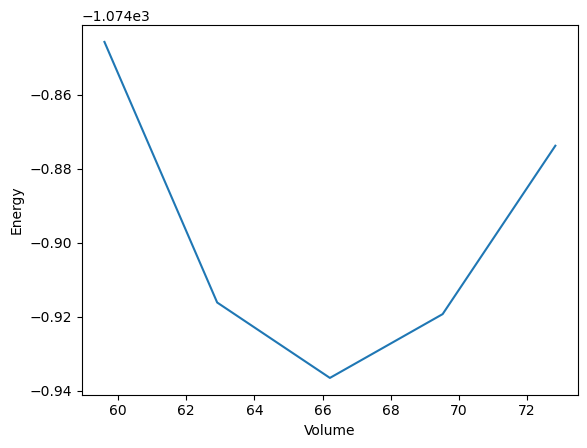

In [21]:
wg.run()

## Load Workflow with pyiron_base

And we can repeat the same process using `pyiron`.

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

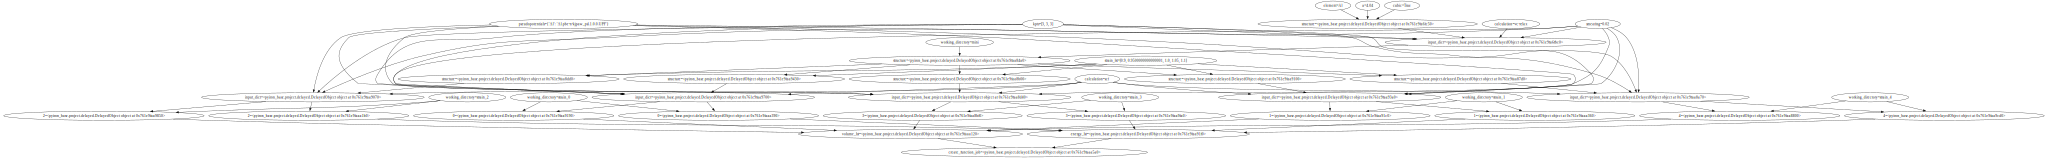

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 1
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 2
The job calculate_qe_411e578f2700d09ba2df9a4c682b4582 was saved and received the ID: 3


[jupyter-pythonworkflow-fl--x---d7231032:10178] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_758c1e24a8384d1f25f5126debddf480 was saved and received the ID: 4
The job get_dict_db80165b1c83d6fa1ef1eef8d8b3188b was saved and received the ID: 5
The job calculate_qe_c74608e7e5992312ade6c5737ad4d4f1 was saved and received the ID: 6


[jupyter-pythonworkflow-fl--x---d7231032:10193] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_97c2cc17b8b86f75ac4b6341cd45956c was saved and received the ID: 7
The job calculate_qe_3c59fd7824f74b10476745bf9830882f was saved and received the ID: 8


[jupyter-pythonworkflow-fl--x---d7231032:10204] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8c518d80d423ba91c334fe6a5d9543bd was saved and received the ID: 9
The job calculate_qe_38624f0e23e56cbc7b388ef79234a0cf was saved and received the ID: 10


[jupyter-pythonworkflow-fl--x---d7231032:10215] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_85562edba169c3c58d84415c89cc95ec was saved and received the ID: 11
The job calculate_qe_78709c5d9efddf18fe3df6c5e14d06ed was saved and received the ID: 12


[jupyter-pythonworkflow-fl--x---d7231032:10226] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c540734353f48fac14af5c29bd88abc9 was saved and received the ID: 13
The job calculate_qe_1e912623736f139236a98ac679574bb4 was saved and received the ID: 14


[jupyter-pythonworkflow-fl--x---d7231032:10242] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_eacb691fa58e50c0936b26623a5e36f9 was saved and received the ID: 15
The job get_list_069bfd570461c3607a17813d3ecb126c was saved and received the ID: 16
The job plot_energy_volume_curve_99f8fb836badb998aff830b255f6b0eb was saved and received the ID: 17


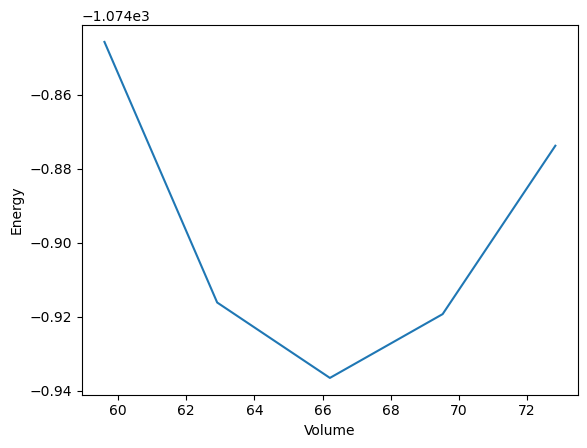

In [25]:
delayed_object_lst[-1].pull()

## Load Workflow with pyiron_workflow

In [ ]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [ ]:
wf = load_workflow_json(file_name=workflow_json_filename)

In [ ]:
wf.draw(size=(10,10))

In [ ]:
wf.run()